## Atividade Realizada pelos alunos:

**João Victor Briganti de Oliveira** - 2504499 \
**Luiz Gustavo Takeda** - 2504510

In [158]:
import numpy as np

data1 = np.load("dataset/s01_1.npy")
data2 = np.load("dataset/s01_2.npy")
data3 = np.load("dataset/s01_3.npy")

data = np.concatenate([data1, data2, data3], axis=0)
data.shape

(24, 1600, 4)

### Funções de filtragem do domínio do tempo

In [159]:
from scipy import signal


# definições de filtros
def butter_bandpass(data, lowcut, highcut, fs=200, order=4):
    nyq = fs * 0.5
    low = lowcut / nyq
    high = highcut / nyq
    b, a = signal.butter(order, [low, high], btype="bandpass")
    return signal.filtfilt(b, a, data, padlen=len(data) // 2)


def butter_notch(data, cutoff, var=1, fs=200, order=4):
    nyq = fs * 0.5
    low = (cutoff - var) / nyq
    high = (cutoff + var) / nyq
    b, a = signal.iirfilter(order, [low, high], btype="bandstop", ftype="butter")
    return signal.filtfilt(b, a, data, padlen=len(data) // 2)

Aplicação dos filtros temporais nos dados

In [160]:
data = data.transpose(0, 2, 1)
print(data.shape)

data_filtered = butter_notch(data, 60)
data_filtered = butter_bandpass(data_filtered, 5.0, 50.0)

from copy import deepcopy

data = deepcopy(data_filtered)


(24, 4, 1600)


### Segmentação dos dados

In [161]:
from scipy.signal import stft

step = 103
segment = 256
print("", data.shape)

n_win = int((data.shape[-1] - segment) / step) + 1
ids = np.arange(n_win) * step

# Janelas do dado no dominio do tempo
chunks_time = np.array([data[:, :, k : (k + segment)] for k in ids]).transpose(
    1, 2, 0, 3
)

# Janelas do dado no domínio da frequência
_, _, chunks_freq = stft(data, fs=200, nperseg=256, noverlap=128)
chunks_freq = np.swapaxes(chunks_freq, 2, 3)

print("Formato (shape) dos dados depois da divisão de janelas")
print(
    f"Dominio do tempo: {chunks_time.shape} - (classes+ensaios, canais, janelas, linhas)"
)
print(
    f"Dominio da frequência:  {chunks_freq.shape} - (classes+ensaios, canais, janelas, linhas)"
)

 (24, 4, 1600)
Formato (shape) dos dados depois da divisão de janelas
Dominio do tempo: (24, 4, 14, 256) - (classes+ensaios, canais, janelas, linhas)
Dominio da frequência:  (24, 4, 14, 129) - (classes+ensaios, canais, janelas, linhas)


### Definição de algumas funções para aplicação de características

Uma característica é uma propriedade individual mensurável ou característica de um fenômeno que está sendo observado. Em EMG, uma característica pode ser extraída no domínio do tempo ou no domínio da frequência. As características a seguir foram retiradas do artigo *EMG Feature Extraction for Tolerance of White Gaussian Noise* \[1\].

### Domínio do tempo

1. Variance of EMG (VAR)

    > $ \frac{1}{N-1}\sum_{i=1}^{N}x_i^2 $

2. Root Mean Square (RMS)

    > $ \sqrt{\frac{1}{N}\sum_{i=1}^{N}|x_i|^2} $

3. Waveform Length (WL)
    
    > $ \sum_{i=1}^{N-1}|x_{i+1} - x_i| $

4. Zero Crossing (ZC)

    > $ \sum_{i=1}^{N}sgn(x_i) $
    
    > $ sgn(x) = \begin{cases} 1 & \text{if } x_i * x_{i+1} \leq 0 \\ 0 & \text{otherwise} \end{cases} $

### Domínio da frequência

1. Median Frequency (FMD)

    > $ \frac{1}{2}\sum_{j=1}^{M}PSD_j $

2. Mean Frequency (FMN)

    > $ \sum_{j=1}^{M} f_j PSD_j \Big/ \sum_{j=1}^{M} PSD_j $
    
    > $ f_j = j \cdot \frac{SampleRate}{2 \cdot M} $

3. Modified Median Frequency (MMDF)

    > $ \frac{1}{2}\sum_{j=1}^{M}A_j $
    
    > $ A_j = Amplitude\ do\ espectro\ j $

4. Modified Frequency Mean (MMNF)

    > $ \sum_{j=1}^{M} f_j A_j \Big/ \sum_{j=1}^{M} A_j $


\[1\] Phinyomark, Angkoon & Limsakul, Chusak & Phukpattaranont, P.. (2008). EMG Feature Extraction for Tolerance of White Gaussian Noise.
[Disponível neste link](https://www.researchgate.net/publication/263765853_EMG_Feature_Extraction_for_Tolerance_of_White_Gaussian_Noise)

É necessário implementar as características, geralmente em formato de funções ou métodos, para que seja possível aplicar tais funções aos dados de entrada e obter as características resultantes. A seguir temos a implementação das características VAR & RMS (domínio do tempo) e FDM & MMDF (domínio da frequência).

In [162]:
# Funções Auxiliares


def PSD(w):
    """definição da função PSD para o sinal no domínio da frequência"""
    return np.abs(w) ** 2


def f(w):
    return np.real(w) * (np.mean(np.diff(np.real(w), axis=-1)) / 2 * len(w))


# Funções de Extração


def var(x):
    return np.sum(x**2, axis=-1) / (np.prod(x.shape) - 1)


def rms(x):
    return np.sqrt(np.sum(np.abs(x) ** 2, axis=-1) / (np.prod(x.shape)))


def wl(x):
    return np.sum(np.diff(np.abs(x)), axis=-1)


def zc(x):
    return np.sum(np.diff(np.sign(x)) != 0, axis=-1)


def fmd(w):
    return np.sum(PSD(w), axis=-1) / 2


def fmn(w):
    psd = PSD(w)
    return np.sum(f(w) * psd, axis=-1) / np.sum(psd, axis=-1)


def mmdf(w):
    return np.sum(np.abs(w), axis=-1) / 2


def mmnf(w):
    return np.sum(f(w) * np.abs(w), axis=-1) / np.sum(np.abs(w), axis=-1)

## Vetor de características

Ao final da implementação e seleção das características, deve ser escolhida as características e então teremos um vetor com todas elas implementadas.

O vetor de características estará organizado da seguinte forma (evisemplo p/ VAR, RMS, RDM e MMDF):

| ID sample | VAR1 | RMS1 | FMD1 | MMDF1 | VAR2 | RMS2 | FMD2 | MMDF2 | Classe |
|:---------:|:----:|:----:|:----:|:-----:|------|------|------|-------|:------:|
|     1     |  v1  |  v1  |  v1  |   v1  | v1   | v1   | v1   | v1    |    0   |
|     2     |  v2  |  v2  |  v2  |   v2  | v2   | v2   | v2   | v2    |    0   |
|    ...    |  ... |  ... |  ... |  ...  | ...  | ...  | ...  | ...   |   ...  |
|     N     |  vN  |  vN  |  vN  |   vN  | vN   | vN   | vN   | vN    |    7   |

## Implementação do vetor

In [163]:
final_data = list()

final_data.append(var(chunks_time))
final_data.append(rms(chunks_time))
final_data.append(wl(chunks_time))
final_data.append(zc(chunks_time))

final_data.append(fmd(chunks_freq))
final_data.append(fmn(chunks_freq))
final_data.append(mmdf(chunks_freq))
final_data.append(mmnf(chunks_freq))

final = np.array(final_data)
final.shape

(8, 24, 4, 14)

É necessário que seja reordenado as dimensões do vetor de características, pois cada característica (de cada canal), deve corresponder à última dimensão do vetor. Por fim, as outras dimensões são concatenadas para o número de amostras.

In [164]:
vis = final.transpose(1, 3, 2, 0)
print("Formato dos dados depois da extração de características")
print(f"{vis.shape} - (classes, janelas, eletrodos, características)")

X = vis.reshape(vis.shape[0] * vis.shape[1], vis.shape[2] * vis.shape[3])
print("Formato para classificação:", X.shape)

Formato dos dados depois da extração de características
(24, 14, 4, 8) - (classes, janelas, eletrodos, características)
Formato para classificação: (336, 32)


#### Função do vetor

In [165]:
import numpy as np


def chunk_array(time, freq):
    chunk = list()

    chunk.append(var(time))
    chunk.append(rms(time))
    chunk.append(wl(time))
    chunk.append(zc(time))

    chunk.append(fmd(freq))
    chunk.append(mmdf(freq))
    chunk.append(fmn(freq))
    chunk.append(mmnf(freq))

    return np.array(chunk)


def build_feature_matrix(chunk, num_classes):
    vis = chunk.transpose(1, 3, 2, 0)
    X = vis.reshape(vis.shape[0] * vis.shape[1], vis.shape[2] * vis.shape[3])

    windows_per_class = vis.shape[1]

    y = list()
    for i in range(8):
        l = [i] * 14
        y.append(l)
    y = y * 3
    y = np.array(y).flatten()

    return X, y

In [166]:
final = chunk_array(chunks_time, chunks_freq)
X, y = build_feature_matrix(final, 24)
y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5,

### Visualização das características

Desenvolvemos aqui uma função que demonstra as amostras em um `scatter plot` bidimensional.

Para que isso fosse possível nos dados, o plot foi organizado de tal forma que, a bidimensionalidade foi organizada por meio dos dois canais presentes no _dataset_.

**Observação**: para que a mesma análise visual seja criada em dados com múltiplos canais, é necessário que seja utilizado uma redução dos N canais em apenas dois. Um método que pode ser utilizado para esta finalidade é o *Principal Component Analisys* (PCA).

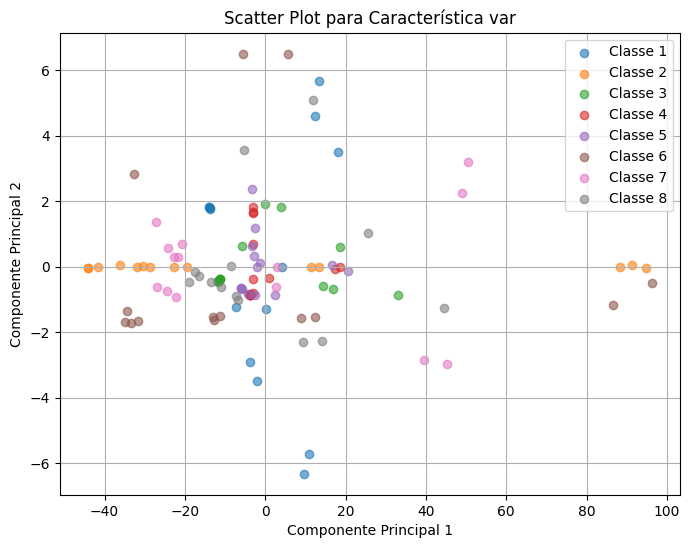

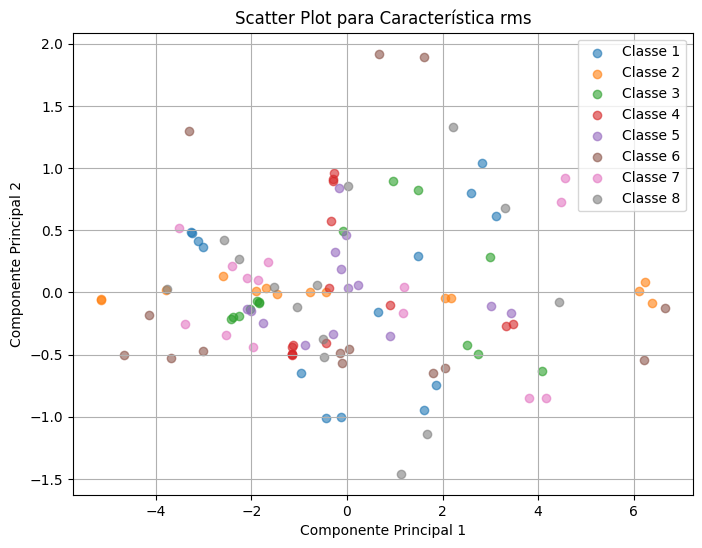

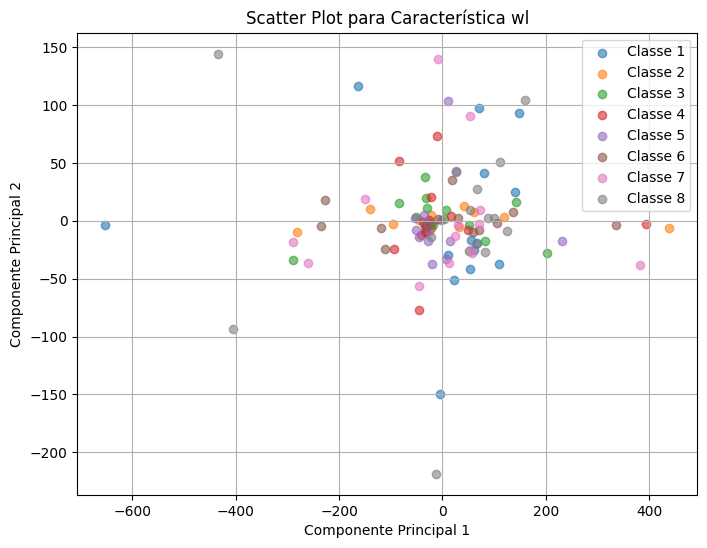

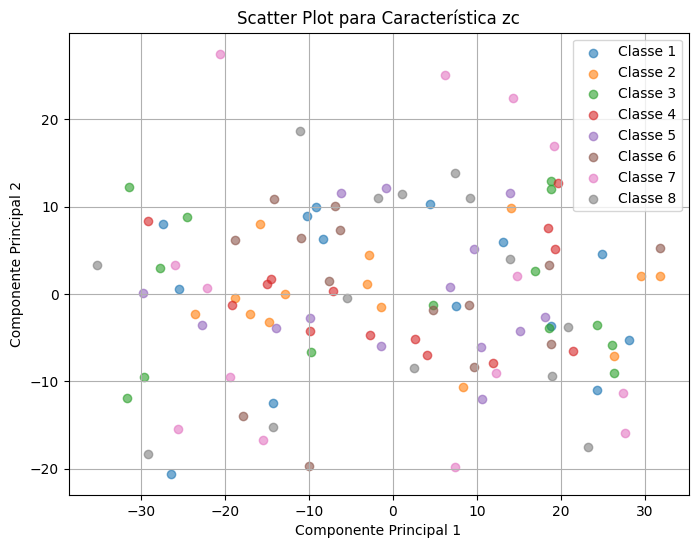

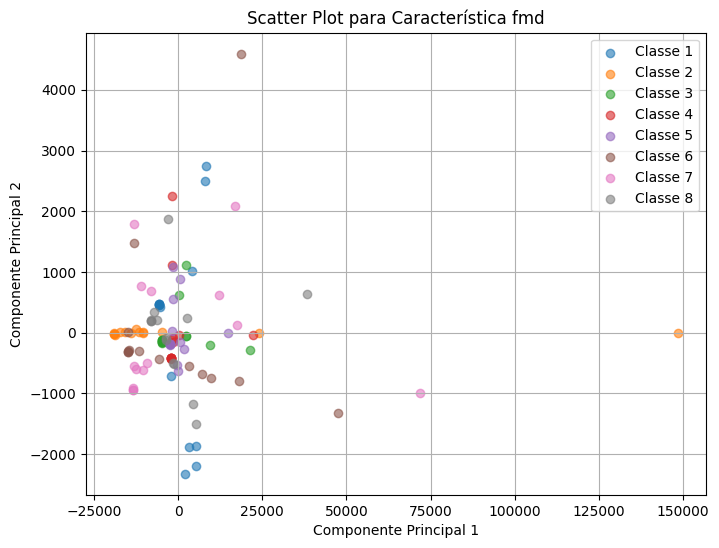

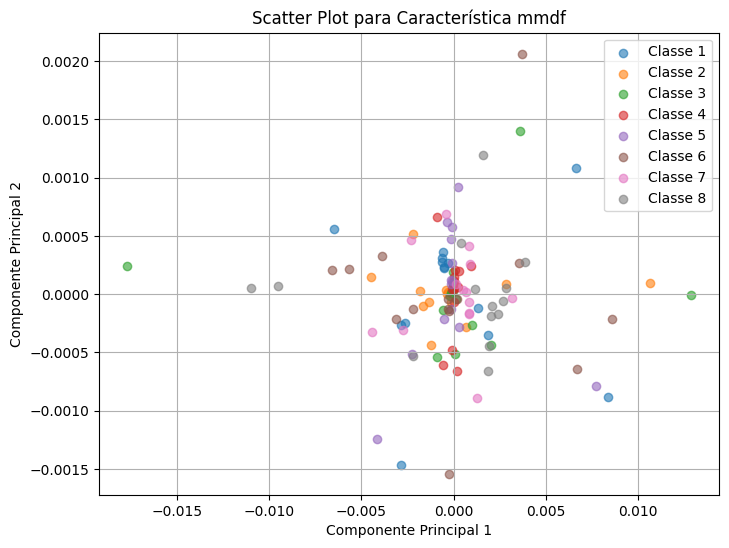

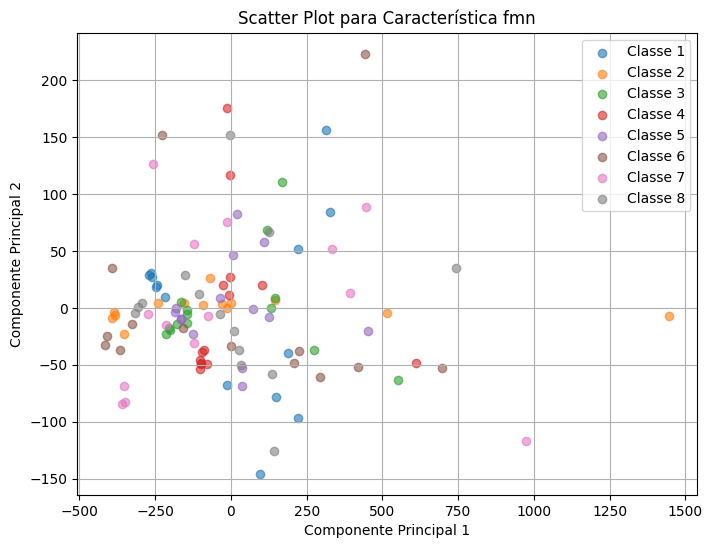

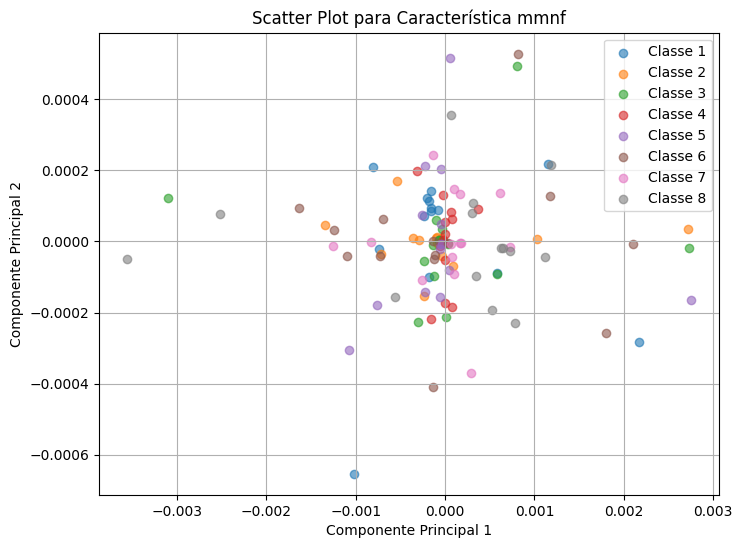

In [167]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Initialize PCA with 2 components
pca = PCA(n_components=2)

feature_names = ["var", "rms", "wl", "zc", "fmd", "mmdf", "fmn", "mmnf"]

# Iterar sobre as 4 características
for feature_idx in range(len(feature_names)):
    plt.figure(figsize=(8, 6))
    for class_idx in range(8):  # Iterar sobre as 8 classes
        # Selecionar os dados da classe e característica atual
        data = vis[class_idx, :, :, feature_idx]
        # Aplicar PCA para reduzir de 4 para 2 dimensões
        data_pca = pca.fit_transform(data.reshape(-1, 4))
        # Scatter plot para a classe atual
        plt.scatter(
            data_pca[:, 0], data_pca[:, 1], label=f"Classe {class_idx + 1}", alpha=0.6
        )

    plt.title(f"Scatter Plot para Característica {feature_names[feature_idx]}")
    plt.xlabel("Componente Principal 1")
    plt.ylabel("Componente Principal 2")
    plt.legend()
    plt.grid(True)
    plt.show()

## SVM

In [168]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

# dividindo as porções de dados em treino e teste (70 e 30% respectivamente)
# com embaralhamento sempre ativo (shuffle=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True)

In [169]:
# modelo de classificador com os parâmetros padrões
clf = SVC(kernel="rbf", gamma="scale")

# criando o modelo de classificação com os dados de treino
clf.fit(X_train, y_train)

SVC()

In [170]:
# aplicando o classificador nos dados de teste
res = clf.predict(X_test)

# obtendo e ajustando os resultados
tot_hit = sum([1 for i in range(len(res)) if res[i] == y_test[i]])
print("Acurácia: {:.2f}%".format(tot_hit / X_test.shape[0] * 100))

Acurácia: 16.83%


## Buffer de Predição
Gerar a criação do buffer, atualmente os dados possuem um shape de `(8, 1600, 4)` -> (classes, valores, eletrodos). Faça o carregamento de um buffer equivalente a uma classe após a outra, ou seja, buffers com o shape igual `(1600, 4)`.

In [171]:
data = np.load("dataset/s01_1.npy")
data.shape

(8, 1600, 4)

In [172]:
def filter_data(data):
    data = data.transpose(1, 0)
    data_filtered = butter_notch(data, 60)
    data_filtered = butter_bandpass(data_filtered, 5.0, 50.0)
    return deepcopy(data_filtered)

In [173]:
def time_chunk(data, step=100, segment=200):
    windows = []
    for start in range(0, data.shape[0] - segment + 1, step):
        window = data[start : start + segment, :]
        windows.append(window)

    return np.array(windows).transpose(2, 0, 1)

In [174]:
def frequency_chunk(data, nperseg=240):
    _, _, freq = stft(data, fs=200, nperseg=nperseg)
    return freq.transpose(0, 2, 1)

In [175]:
def chunk_array(time, freq):
    chunk = list()

    chunk.append(var(time))
    chunk.append(rms(time))
    chunk.append(wl(time))
    chunk.append(zc(time))

    chunk.append(fmd(freq))
    chunk.append(mmdf(freq))
    chunk.append(fmn(freq))
    chunk.append(mmnf(freq))

    return np.array(chunk)

In [176]:
def build_feature_matrix(chunk, labels=None):
    samples, channels, features = chunk.shape
    X = chunk.reshape(samples, channels * features)

    if labels is None:
        y = np.zeros(samples)
    else:
        y = np.array(labels).flatten()

    return X, y

In [ ]:
res = []

for d in data:
    data_filter = filter_data(data[0])
    time = time_chunk(data_filter.T)
    frequency = frequency_chunk(data_filter)
    chunk = chunk_array(time, frequency)
    X, y = build_feature_matrix(chunk)
    res.extend(clf.predict(X[:, 0:32]))
    res.extend(clf.predict(X[:, 28:60]))

res

[np.int64(3),
 np.int64(3),
 np.int64(3),
 np.int64(3),
 np.int64(1),
 np.int64(3),
 np.int64(3),
 np.int64(3),
 np.int64(3),
 np.int64(3),
 np.int64(3),
 np.int64(3),
 np.int64(3),
 np.int64(3),
 np.int64(3),
 np.int64(3),
 np.int64(3),
 np.int64(3),
 np.int64(3),
 np.int64(3),
 np.int64(1),
 np.int64(3),
 np.int64(3),
 np.int64(3),
 np.int64(3),
 np.int64(3),
 np.int64(3),
 np.int64(3),
 np.int64(3),
 np.int64(3),
 np.int64(3),
 np.int64(3),
 np.int64(3),
 np.int64(3),
 np.int64(3),
 np.int64(3),
 np.int64(1),
 np.int64(3),
 np.int64(3),
 np.int64(3),
 np.int64(3),
 np.int64(3),
 np.int64(3),
 np.int64(3),
 np.int64(3),
 np.int64(3),
 np.int64(3),
 np.int64(3),
 np.int64(3),
 np.int64(3),
 np.int64(3),
 np.int64(3),
 np.int64(1),
 np.int64(3),
 np.int64(3),
 np.int64(3),
 np.int64(3),
 np.int64(3),
 np.int64(3),
 np.int64(3),
 np.int64(3),
 np.int64(3),
 np.int64(3),
 np.int64(3),
 np.int64(3),
 np.int64(3),
 np.int64(3),
 np.int64(3),
 np.int64(1),
 np.int64(3),
 np.int64(3),
 np.in